<a href="https://colab.research.google.com/github/Sts87/FlightOnTime/blob/feature%2Fmodel-training/FlightOnTime-Analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### CARGA DE DATOS

In [115]:
# DATASET
# Airline:  aerolínea
# Flight:   tipo de aeronave
# Time:     hora de salida en minutos (desde medianoche)
# Length:   tiempo de vuelo en minutos
url = 'https://raw.githubusercontent.com/Sts87/FlightOnTime/refs/heads/main/data/Airlines.csv'
df = pd.read_csv(url)

### INSPECCIÓN INICIAL

In [116]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [117]:
df.shape

(539383, 9)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


### LIMPIEZA DE DATOS

In [119]:
# ELIMINAR COLUMNA CODIGO
df.drop('id', axis=1, inplace=True)

In [120]:
(df == '').sum()

,0
Airline,0
Flight,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Time,0
Length,0
Delay,0


In [121]:
#Esta línea tiene una advertencia por no haber valores nulos
#Esto no debiera afectar al dataset ni el analisis ni el machinelearning

df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
df.replace('', np.nan, inplace=True)
df.isnull().sum()

#Alternativa para evitar adventerncia
#df.replace('', np.nan, inplace=True)

,0
Airline,0
Flight,0
AirportFrom,0
AirportTo,0
DayOfWeek,0
Time,0
Length,0
Delay,0


### ANÁLISIS ESTADÍSTICO

In [122]:
# VARIABLES NÚMERICAS
# RMC: Tomar en cuenta solo 'Time', 'Length'
df[['Time', 'Length']].describe().round(1)

,Time,Length
count,539383.0,539383.0
mean,802.7,132.2
std,278.0,70.1
min,10.0,0.0
25%,565.0,81.0
50%,795.0,115.0
75%,1035.0,162.0
max,1439.0,655.0


In [123]:
# VARIABLES CATEGÓRICAS
df.describe(include='object')

,Airline,AirportFrom,AirportTo
count,539383,539383,539383
unique,18,293,293
top,WN,ATL,ATL
freq,94097,34449,34440


### PROPORCIÓN DE CLASES DE LA VARIABLE OBJETIVO

In [124]:
# IDENTIFICAR SI HAY DESBALANCEO
# No hay desbalanceo: proporcion 55-45%
df_cnt = df['Delay'].value_counts()
df_pct = df['Delay'].value_counts(normalize=True).round(2) * 100

df_delay = pd.concat([df_cnt, df_pct], axis=1)
df_delay

,count,proportion
Delay,,
0,299119,55.0
1,240264,45.0


### NUEVAS VARIABLES

In [125]:
# Nuevas variables candidatas:
# Hour (hh:mm)
df['Hour'] = df['Time'].apply(lambda x: str(x // 60).zfill(2) + ":" + str(x % 60).zfill(2))
df['Hour'] = pd.to_datetime(df['Hour'], format="%H:%M")

# Time of day: Momento del dia de la salida del vuelo
clases = [0, 360, 720, 1080, 1440]
labels = ['Early morning', 'Morning', 'Afternoon', 'Night']
df['TimeDay'] = pd.cut(x=df['Time'], bins=clases, labels=labels, include_lowest=True)

# Duration
clases = [0, 90, 180, 960]
labels = ['Short', 'Medium', 'Long']
df['Duration'] = pd.cut(x=df['Length'], bins=clases, labels=labels, include_lowest=True)

### ANALISIS DESCRIPTIVO

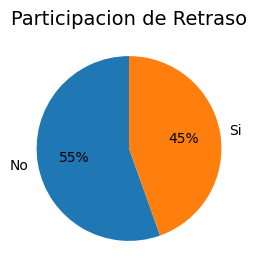

In [126]:
# Retraso: 55% a tiempo, 45% retraso
plt.figure(figsize=(4, 3))
plt.pie(df['Delay'].value_counts(), labels=['No','Si'], autopct='%1.0f%%', startangle=90)
plt.title('Participacion de Retraso', fontsize=14)

plt.show()
# plt.savefig("participacion_target.png", bbox_inches='tight', dpi=300)
# plt.close()

In [130]:
df2 = df.groupby(['DayOfWeek', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('DayOfWeek')['NumFlights'].transform(lambda x: x / x.sum())
df2

,DayOfWeek,Delay,NumFlights,PctFlights
0,1,0,38739,0.532356
1,1,1,34030,0.467644
2,2,0,39427,0.552663
3,2,1,31913,0.447337
4,3,0,47492,0.529182
5,3,1,42254,0.470818
6,4,0,50201,0.548975
7,4,1,41244,0.451025
8,5,0,49733,0.583392
9,5,1,35515,0.416608


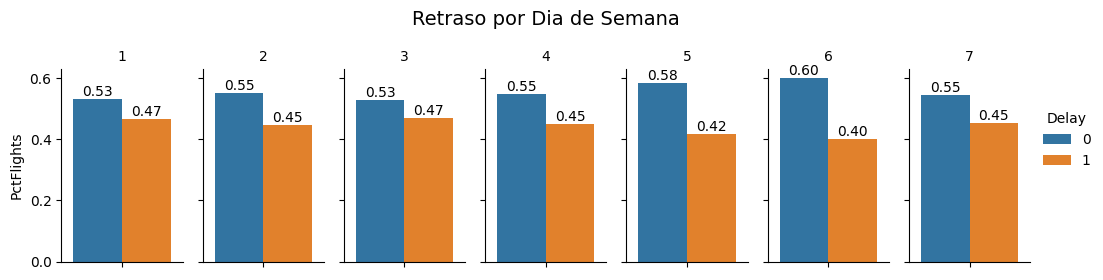

In [134]:
# Retraso por Dia de semana:
# -Dias 5 y 6 tienen menores retrasos
df2 = df.groupby(['DayOfWeek', 'Delay'])['Delay'].count().reset_index(name='NumFlights')
df2['PctFlights'] = df2.groupby('DayOfWeek')['NumFlights'].transform(lambda x: x / x.sum())

g = sns.catplot(
       data=df2, hue="Delay", y="PctFlights", col="DayOfWeek",
       kind="bar", height=2.5, aspect=.6
    )

for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')


g.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
g.fig.suptitle("Retraso por Dia de Semana", y=1.1, fontsize=14)

plt.show()
# plt.savefig("distribucion_delay_dia_semana.png", bbox_inches='tight', dpi=300)
# plt.close()